In [ ]:
!pip install -qU albumentations

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data.dataloader
import torchvision.io
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.io
from skimage.io import imshow, imread
import matplotlib.pyplot as plt
import numpy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torchsummary  import summary
from torch.utils.tensorboard import SummaryWriter

In [ ]:
writer = SummaryWriter("runs/ISIC/tensorboard")

%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 0
LEARNING_RATE = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50
VALID_LOSS_MIN = np.Inf

In [ ]:
train_dataset_path = "drive/MyDrive/Pesquisa/DataBase/Train/Train_Dataset/ISIC_2017_Training_Data_Sample"
train_gt_dataset_path = 'drive/MyDrive/Pesquisa/DataBase/Train/Train_GT_Dataset/ISIC_2017_GT_Training_Data_Sample'

test_gt_dataset_path = "drive/MyDrive/Pesquisa/DataBase/Teste/ISIC_2017_Test_GT"
test_dataset_path = "drive/MyDrive/Pesquisa/DataBase/Teste/ISIC_2017_Test__Data"

validation_dataset_path = "drive/MyDrive/Pesquisa/DataBase/Validation/Validation_Dataset/ISIC_2017_Training_Validation"
validation_gt_dataset_path = "drive/MyDrive/Pesquisa/DataBase/Validation/Validation_GT_Dataset/ISIC_2017_GT_Validation"

In [ ]:
train_transform = A.Compose([A.Resize(height=224, width=224), A.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0], max_pixel_value=255.0), ToTensorV2()])
valid_transform = A.Compose([A.Resize(height=224, width=224), A.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0], max_pixel_value=255.0), ToTensorV2()])

train_transform_ = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
gt_transform_ = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize([0.0], [1.0])])

In [ ]:
train_transform = A.Compose([A.Resize(height=244, width=244),
                     A.Rotate(limit=30, p=1.0),
                     A.HorizontalFlip(p=0.5),
                     A.VerticalFlip(p=0.1),
                     A.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225], max_pixel_value=255.0,),
                    ToTensorV2(),],)

In [ ]:
encoder_1 = [16, 16] 
encoder_2 = ["M", 32, 32]
encoder_3 = ["M", 64, 64]
encoder_4 = ["M", 128, 128]
encoder_5 = ["M", "D", 256, 256]

encoder_final = ["M", "D", 512, 512, "D", "U"]

decoder_1 = [256, 256, 256, "D","U"] 
decoder_2 = [128, 128, 128, "D", "U"]
decoder_3 = [64, 64, 64, "U"]
decoder_4 = [32, 32, 32, "U"]
decoder_5 = [16, 16, 2]#, "S"]

class U_Net(nn.Module):

  def __init__(self, in_channels=3):
    super(U_Net, self).__init__()
    
    self.in_channels = in_channels

    self.conv_encoder_1 = self.create_architecture(encoder_1, self.in_channels)
    self.conv_encoder_2 = self.create_architecture(encoder_2, 16)
    self.conv_encoder_3 = self.create_architecture(encoder_3, 32)
    self.conv_encoder_4 = self.create_architecture(encoder_4, 64)
    self.conv_encoder_5 = self.create_architecture(encoder_5, 128)
    
    self.conv_encoder_final = self.create_architecture(encoder_final, 256)

    self.conv_decoder_1 = self.create_architecture(decoder_1, 512)
    self.conv_decoder_2 = self.create_architecture(decoder_2, 256)
    self.conv_decoder_3 = self.create_architecture(decoder_3, 128)
    self.conv_decoder_4 = self.create_architecture(decoder_4, 64)
    self.conv_decoder_5 = self.create_architecture(decoder_5, 32)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.conv_encoder_1(x)
    c1 = x
    x = self.conv_encoder_2(x)
    c2 = x
    x = self.conv_encoder_3(x)
    c3 = x
    x = self.conv_encoder_4(x)
    c4 = x
    x = self.conv_encoder_5(x)
    c5 = x
    
    x = self.conv_encoder_final(x)
    x = torch.cat((x, c5), 1)

    x = self.conv_decoder_1(x)
    x = torch.cat((x, c4), 1)

    x = self.conv_decoder_2(x)
    x = torch.cat((x, c3), 1)

    x = self.conv_decoder_3(x)
    x = torch.cat((x, c2), 1)

    x = self.conv_decoder_4(x)
    x = torch.cat((x, c1), 1)
    x = self.conv_decoder_5(x)

    return x

  def create_architecture(self, architecture, in_channels):
    layers = []
    for i in architecture:
      if type(i) == int:
        out_channels = i

        layers += [nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=1, bias=False), nn.BatchNorm2d(i), nn.ReLU()]
        in_channels = i
      elif i == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

      elif i == "D":
        layers += [nn.Dropout(0.25)]

      elif i == "U":
        layers += [nn.ConvTranspose2d(in_channels, int(in_channels/2), kernel_size=(2, 2), stride=(2, 2))]
        in_channels = int(in_channels/2)
      elif i == "S":
        layers += [nn.Softmax(2)]
    return nn.Sequential(*layers)

In [ ]:
class Conv_Simples(nn.Module):

  def __init__(self, in_channels):
    super(Conv_Simples, self).__init__()

    self.in_channels = in_channels
    self.conv1 = nn.Conv2d(in_channels, 16, (3, 3), padding=1 )
    self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)

    self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    self.upconv2 = nn.ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))

    self.softmax = nn.Softmax(dim=2)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.maxpool(F.relu(self.conv1(x)))
    x = self.maxpool(F.relu(self.conv2(x)))
    x = self.upconv1(x)
    x = self.upconv2(x)
    x = self.softmax(x)
    return x

In [ ]:
class dataset_isic_class(torch.utils.data.Dataset):
  def __init__(self, image_dir, gt_dir, transform=None, gt_transform=None):
    self.image_dir = image_dir
    self.gt_dir = gt_dir
    self.transform = transform
    self.gt_transform = gt_transform
    self.image_name = sorted(os.listdir(image_dir))
    self.gt_name = sorted(os.listdir(gt_dir))

  def __len__(self):
    return len(self.image_name)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.image_name[index])
    gt_path = os.path.join(self.gt_dir, self.gt_name[index])
    image = np.array(Image.open(image_path).convert("RGB"))
    gt = np.array(Image.open(gt_path).convert("L"), dtype=np.float32)
    gt[gt==255.0] = 1.0
    if self.transform is not None:
      image = self.transform(image)
      gt = self.gt_transform(gt)
      
      #augumentation = self.transform(image=image, gt=gt)
      #image = augumentation["image"]
      #gt = augumentation["gt"]

    return image, gt


In [ ]:
x = torch.randn((1, 3, 224, 224)).to(DEVICE)
print(f'Input:{x.shape}')
model = U_Net(3).to(DEVICE)
with torch.no_grad():
    out = model(x)
print(f'Out:{out.shape}')
summary(model, (3, 224, 224))

In [ ]:
train_dataset = dataset_isic_class(test_dataset_path, test_gt_dataset_path, transform=train_transform_, gt_transform=gt_transform_)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = dataset_isic_class(validation_dataset_path, validation_gt_dataset_path, transform=train_transform_, gt_transform=gt_transform_)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
img, gt = next(iter(valid_loader))

print(img.shape, gt.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


torch.Size([32, 3, 224, 224])


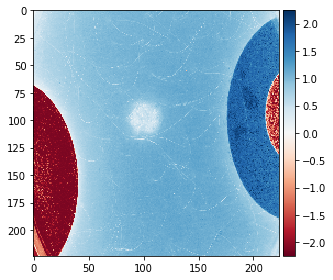

In [ ]:
print(img.shape)

imshow(img[3][0].detach().numpy())
plt.show()

torch.Size([32, 1, 224, 224])


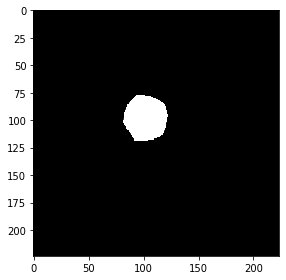

In [ ]:
print(gt.shape)

imshow(gt[3][0].detach().numpy())
plt.show()

In [ ]:
train_on_gpu = torch.cuda.is_available()
print(torch.cuda.is_available())

model = U_Net(3).to(DEVICE) #CRIANDO O MODELO

#TESTES DE PARAMETROS E FUNCIONAMENTO DA ARQUITETURA DA REDE

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

False
8563058


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  torch.load_state_dict(checkpoint["state_dict"])

In [ ]:
def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)

      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)

  print(f"Acuracia: {num_correct*100/num_pixels}")
  model.train()

In [ ]:
def dice_score(loader, model, device="cuda"):
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)

      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

      dice_score += (2*(preds*y).sum()) / ((preds+y).sum() + 1e-8)

  print(f"Dice Score: {dice_score/len(loader)}")
  model.train()

In [ ]:
def jaccard(arg1, arg2):
  arg1 = arg1.detach().numpy()
  arg2 = arg2.detach().numpy()
  intersection = np.logical_and(arg1, arg2)
  union = np.logical_or(arg1, arg2)
  similarity = intersection.sum()/float(union.sum())
  print(f"Jaccard: {similarity}")

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)
  
  for bth_index, (data, target) in enumerate(loop):
    data = data.to(device=DEVICE)
    target = target.float().to(DEVICE)

    with torch.cuda.amp.autocast():
      output = model(data)
      loss = loss_fn(output, target)
      
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    loop.set_postfix(loss=loss.item())

In [ ]:
def eval_fn(loader, model, optimizer):
  loop = tqdm(loader)
  model.eval()
  for bth_index, (valid_data, valid_target) in enumerate(loop):
    valid_data = valid_data.to(device=DEVICE)
    valid_target = valid_target.to(device=DEVICE)

    with torch.cuda.amp.autocast() and torch.no_grad():
      valid_output = model(valid_data)
      loss = loss_fn(valid_output, valid_target)

    loop.set_postfix(loss=loss.item())
  model.train()

In [ ]:
for epoch in range(EPOCHS):
  train_fn(train_loader, model, optimizer, loss_fn, scaler)
  eval_fn(valid_loader, model, optimizer)
  dice_score(valid_loader, model, DEVICE)

In [ ]:
print("Inicio do Treinamento")

step = 0

for epoch in range(EPOCHS):
  
  num_correct = 0
  num_pixels = 0
  train_loss = 0.0
  valid_loss = 0.0
  dice_score = 0.0

  loop = tqdm(train_loader)
  valid_loop = tqdm(valid_loader)

  model.train()

  for bth_index, (data, target) in enumerate(loop):

    if train_on_gpu:
      data, target = data.cuda(), target.float().cuda()
    
    output = model(data)
    loss = loss_fn(output, target)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    train_loss += loss.item()
    loop.set_postfix(loss=loss.item())

  model.eval()

  for bth_index, (valid_data, valid_target) in enumerate(valid_loop):
    
    if train_on_gpu:
      valid_data, valid_target = valid_data.cuda(), valid_target.float().cuda()

    valid_output = model(valid_data)

    imshow(torch.sigmoid(valid_output[0][0]).cpu().detach().numpy())
    plt.show()
    imshow(valid_target[0][0].cpu().detach().numpy())
    plt.show()
    
    preds = (torch.sigmoid(valid_output) > 0.5).float()
    dice_score += (2*(preds*valid_target).sum()) / ((preds+valid_target).sum() + 1e-8)
    num_correct += (preds == valid_target).sum()
    num_pixels += torch.numel(preds)

    loss = loss_fn(valid_output, valid_target)
    valid_loss += loss.item()
    valid_loop.set_postfix(loss=loss.item())

  valid_loss = valid_loss/len(valid_loader)
  train_loss = train_loss/len(train_loader)
  dice_score = dice_score/len(valid_loader)
  accuracy = ((num_correct/num_pixels)*100)/len(valid_loader)
  writer.add_scalar('Training Loss', train_loss, global_step=step)
  writer.add_scalar('Validation Loss', valid_loss, global_step=step)
  writer.add_scalar('Validation Accuracy', dice_score, global_step=step)
  writer.add_scalar('Validation Dice Score', accuracy, global_step=step)
  step += 1

  print(f"Dice Score: {dice_score}")
  print(f"Acurácia: {accuracy}")
  print('Epoch: {} \tTraining Loss: {:.6f}  \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

  if valid_loss <= VALID_LOSS_MIN:
    print('Validation loss decreased ({:.6f} ---> {:.6f}). Saving Model ...'.format(VALID_LOSS_MIN, valid_loss))
    torch.save(model.state_dict(), 'model_ISIC.pt')
    VALID_LOSS_MIN = valid_loss